In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as pp
from operator import itemgetter
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import norm
from sklearn.model_selection import KFold

In [2]:
R = np.loadtxt("rating.txt", dtype="int", usecols=(0,1,3))
#R = np.loadtxt("simple.txt", dtype="int", usecols=(0,1,2))
#T = np.loadtxt("trust.txt", dtype="int", usecols=(0,1))
num_users = max(R[:,0])
num_items = max(R[:,1])
X = csr_matrix((R[:,2],(R[:,0]-1,R[:,1]-1)), shape=(num_users,num_items))
num_ratings = X.getnnz()
# rebuild R to include only unique entries and be zero based
coo = X.tocoo()
R = np.column_stack((coo.row, coo.col, coo.data))
np.random.seed(42)
np.random.shuffle(R)

In [3]:
sparsity = 100-num_ratings/(num_users*num_items)*100
per_user = X.astype(bool).sum(1).A1
mean_reviews_per_user = np.mean(per_user)
per_item = X.astype(bool).sum(0).A1
mean_reviews_per_item = np.mean(per_item)

stats = {
    "Data sparsity": str(round(sparsity,5))+"%",
    "Number of users": num_users,
    "Number of items": num_items,
    "Number of ratings": num_ratings,
    "Number of users with no ratings": len(per_user[per_user==0]),
    "Minimum reviews per user": min(per_user),
    "Maximum reviews per user": max(per_user),
    "Mean reviews per user:": int(round(mean_reviews_per_user)),
    "Minimum reviews per item": min(per_item),
    "Maximum reviews per item": max(per_item),
    "Mean reviews per item:": int(round(mean_reviews_per_item))
}

for k, v in stats.items():
    print(f'{k:<35} {v}')

Data sparsity                       99.98611%
Number of users                     22166
Number of items                     296277
Number of ratings                   912441
Number of users with no ratings     2
Minimum reviews per user            0
Maximum reviews per user            5337
Mean reviews per user:              41
Minimum reviews per item            1
Maximum reviews per item            1742
Mean reviews per item:              3


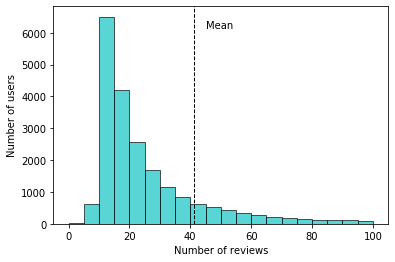

In [4]:
max_user_reviews = 100
x = sorted([n for n in per_user if n <= max_user_reviews]) 
plt.hist(x, bins=int(max_user_reviews/5), color='c', edgecolor='k', alpha=0.65)
plt.axvline(mean_reviews_per_user, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_user + mean_reviews_per_user/10, max_ - max_/10, 'Mean')
plt.show()

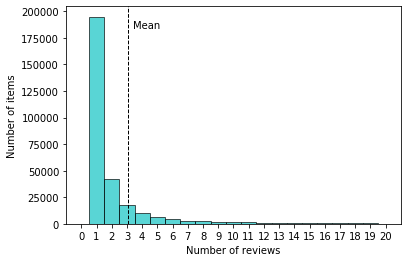

In [5]:
max_item_reviews = 21
x = sorted([n for n in per_item if n <= max_item_reviews])
plt.hist(x, bins=np.arange(21)-0.5, color='c', edgecolor='k', alpha=0.65)
plt.xticks(range(21))
plt.xlim([-1, 21])
plt.axvline(mean_reviews_per_item, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of reviews')
plt.ylabel('Number of items')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_item + mean_reviews_per_item/10, max_ - max_/10, 'Mean')
plt.show()

In [6]:
def get_cosine_similarity(A):
    col_normed_mat = pp.normalize(A.tocsc(), axis=1)
    sim = col_normed_mat * col_normed_mat.T

    return sim.tolil()

In [7]:
def get_neighbours(S, user_id):
    all_neighbours = S[user_id]
    pairs = zip(all_neighbours.data[0], all_neighbours.rows[0])
    ordered = list(filter(lambda x: x[1] != user_id, sorted(pairs, key=itemgetter(0), reverse=True)))
    
    return ordered

In [8]:
def get_average_ratings(M):
    sums = M.sum(axis=1).A1
    counts = np.diff(M.indptr)
    counts[counts==0] = 1
    
    return sums / counts

In [9]:
import time
def predict(M, S, A, k, user_id, item_id):
    # get neighbours of user_id that rated item_id, sorted by similarity
    #s=time.perf_counter()
    neighbours_data = get_neighbours(S, user_id)
    all_neighbours = [x[1] for x in neighbours_data]  
    ratings = M[:,item_id]
    raters, _ = ratings.nonzero()

    rating_neighbours = list(filter(lambda x: x[1] in set(raters), neighbours_data))[:k]
    
    if len(rating_neighbours) == 0:
        return 3
    
    weights, neighbours = map(list, zip(*rating_neighbours))
    
    #print(time.perf_counter()-s)
      
    # return average rating in 1-5 scale if there are no neighbours left or their weights are 0
    #if sum(weights) == 0:
    #    return 3

    # compute users' average ratings and weights
    #s=time.perf_counter()
    user_avg = A[user_id]
    neighbours_avg = A[neighbours]

    # compute weighted ratings
    ratings = sum(weights * (M[neighbours][:,item_id].T - neighbours_avg).A1)/sum(weights)
    rating = int(np.round(user_avg + ratings))
    
    #print(time.perf_counter()-s)   
    if rating < 1:
        return 1
    elif rating > 5:
        return 5
    else:
        return rating

In [14]:
def evaluate(R, knn, fsim, train_index, test_index):
    # create a training matrix with the same shape as ratings R
    print("preparing evaluation data...")
    train_set = R[train_index]
    U = csr_matrix((train_set[:,2],(train_set[:,0],train_set[:,1])), shape=(num_users, num_items))
    S = fsim(U)
    A = get_average_ratings(U)
    # get a view of the test set
    y = R[test_index[0]:test_index[-1]+1][0:100]
    #print(len(y))
    #print(len(np.unique(y[:,0])))
    # get predictions for the test set
    print("running predictions...")
    s = time.perf_counter()
    predictions = np.fromiter((predict(U, S, A, knn, u, i) for u,i,_ in y), y.dtype, count=len(y))
    print(time.perf_counter()-s)
    diff = y[:,2] - predictions
    
    # return RMSE
    return np.sqrt(diff.dot(diff)/len(y))

In [15]:
#S = get_cosine_similarity(X)
#A = get_average_ratings(X)
#predict(X, S, A, 2, 0, 3)
#%timeit X.sum(axis=1).A1 / np.diff(X.indptr)

In [16]:
kf = KFold(n_splits=10)
err = []
for train_index, test_index in kf.split(R):
    print("next split")
    rmse = evaluate(R, 13, get_cosine_similarity, train_index, test_index)
    err.append(rmse)
    print("--")
print(np.mean(err))

next split
preparing evaluation data...
running predictions...
2.1263962289958727
--
next split
preparing evaluation data...
running predictions...
2.4532575459888903
--
next split
preparing evaluation data...
running predictions...
2.243939946987666
--
next split
preparing evaluation data...
running predictions...
2.654582636008854
--
next split
preparing evaluation data...
running predictions...
2.5330110889917705
--
next split
preparing evaluation data...
running predictions...
1.9323907940124627
--
next split
preparing evaluation data...
running predictions...
2.669222891010577
--
next split
preparing evaluation data...
running predictions...
2.0136980730021605
--
next split
preparing evaluation data...
running predictions...
2.5523631690011825
--
next split
preparing evaluation data...
running predictions...
2.1698642569972435
--
1.538032953964244
